<a href="https://colab.research.google.com/github/vberestyukova/Data-analysis-and-machine-learning/blob/main/HW2_Berestyukova.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Классификация вершин (10 баллов) 

Будем решать задачу предсказания влиятельности вершин как задачу классификации. Разобьем отрезок $\left [ s_{i}^{min},s_{i}^{max}\right ]$ на $k$ одинаковых отрезков, и разметим вершины, чьи значения $s_{i}$ лежит в $\left[s_i^{(j-1)},s_i^{(j)} \right)$, $j = 1, 2 \dots k$, меткой $j$, т.е. значение класса $l_i$ для $i$-ой вершины определяется: 

$$
l_i=\left [k \frac{s_i-s_i^{min}}{s_i^{max}-s_i^{min}}\right]. 
$$

Для k=2 задача превращается в задачу бинарной классификации. 

1. Вычислите различные структурные признаки вершин: центральности, кластеризацию, k-core

2.  Исследуйте корреляцию между признаками и целевой переменой 

3. Разделите выборку на обучающую и тестовую, постройте модели классификации (бинарной), выведите метрики качества, подберите оптимальные гиперпараметры

4. Проанализируйте важность признаков 

1.Вычислите различные структурные признаки вершин: центральности, кластеризацию, k-core

In [ ]:
import networkx as nx
import random
import pandas as pd
import numpy as np
from itertools import combinations
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from networkx.algorithms import community as com
import itertools

Загрузим рассматриваемый граф, посмотрим его свойства: является ли он связным, кол-во ребер, вершин, плотность(т.к. вывелась 1, значит граф связный).


In [ ]:
G=nx.read_edgelist('ca-GrQc.mtx') #создали граф G
df = pd.read_csv('spreading_data_ca-GrQc.csv') # создали метки
print('number of edges:',G.number_of_edges())
print('density:',nx.density(G)) 
print('number of nodes:',G.number_of_nodes()) 
spread=list(df['spreading ability'])
len(list(nx.connected_components(G))) 

number of edges: 13422
density: 0.0015530402828935425
number of nodes: 4158


1

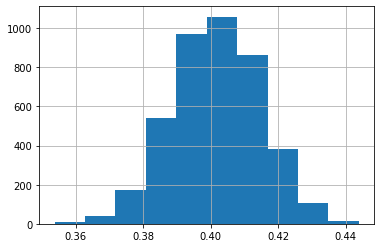

In [ ]:
df['spreading ability'].hist()

In [ ]:
pos=nx.spring_layout(G,iterations=100) # для определения координат вершин

Найдем степень важности узлов. У нас есть N вершин. Сперва рассмотрим центральность по степени, т.е покажем долю ближ. соседей i-ой вершины из макс. возм. N-1.

In [ ]:
centr = nx.degree_centrality(G)

Но сама по себе такая мера бесполезна. Поэтому рассмотрим другие центральности. Рассмотрим центральность по собственному вектору. Определяется как i-ая компонента собственного вектора матрицы смежности графа, которая соответ. самой большой лямбде(в формуле). Хотим узнать, с какими узлами связан наш узел

In [ ]:
centrality = nx.eigenvector_centrality(G) #Вычисляет центральность собственного вектора для графа G
centrality

{'19': 1.9785263129130207e-07,
 '1': 1.930277900501332e-08,
 '1751': 1.893130188958897e-08,
 '2408': 5.769049733488967e-07,
 '3078': 1.4507517976522905e-08,
 '3609': 4.788869799969411e-10,
 '3958': 5.649891695602311e-10,
 '612': 2.124002239207916e-08,
 '2': 2.1229993227461844e-08,
 '2405': 4.655275503599887e-10,
 '3096': 9.252739488626244e-07,
 '3696': 2.124002239207916e-08,
 '222': 2.2044562318871336e-06,
 '3': 2.1891136725420227e-06,
 '743': 9.72078031977371e-06,
 '1829': 2.652667346690609e-06,
 '2036': 1.629694351681619e-05,
 '2037': 6.860877699580879e-05,
 '1742': 4.611683412199407e-08,
 '4': 4.611683412199407e-08,
 '3017': 4.611683412199407e-08,
 '3928': 4.611683412199407e-08,
 '4043': 1.96533805432961e-06,
 '3230': 1.6940593496721464e-07,
 '5': 3.7152091945365632e-09,
 '98': 0.1443013670467533,
 '6': 0.14334075901979934,
 '118': 0.14850111781892164,
 '190': 0.020220205295058566,
 '251': 0.14566473627764637,
 '351': 0.14453071054874192,
 '437': 0.1535743805226768,
 '471': 0.143892

Центральность по близости определяет, насколько данный узел близок ко всем остальным узлам в сети

In [ ]:
close_centr = nx.closeness_centrality(G) #Вычисляет центральность близости для узлов
close_centr

{'19': 0.18410097431355182,
 '1': 0.15904656234456901,
 '1751': 0.15897965427566163,
 '2408': 0.17122497734574513,
 '3078': 0.1462599394834987,
 '3609': 0.13727626973119345,
 '3958': 0.138170577677325,
 '612': 0.1485067162046299,
 '2': 0.1484748910636474,
 '2405': 0.12928407041114637,
 '3096': 0.17427577243952544,
 '3696': 0.1485067162046299,
 '222': 0.19891855679969375,
 '3': 0.19858596474466153,
 '743': 0.21735947712418302,
 '1829': 0.2027903800185375,
 '2036': 0.22951634275618374,
 '2037': 0.22600989506877617,
 '1742': 0.14161613408734755,
 '4': 0.14161613408734755,
 '3017': 0.14161613408734755,
 '3928': 0.14161613408734755,
 '4043': 0.16495377167572714,
 '3230': 0.16079371833056125,
 '5': 0.1385251091339265,
 '98': 0.2204135737009544,
 '6': 0.22240650580493285,
 '118': 0.22283570088448137,
 '190': 0.20595521204914785,
 '251': 0.22396422606540595,
 '351': 0.21849048670240723,
 '437': 0.2315619429590018,
 '471': 0.21846752154719362,
 '530': 0.2185479207192051,
 '674': 0.2204369498356

Также есть центральность по посредничеству. Центральность по посредничеству выражает, сколько кратчайших путей между всеми узлами сети проходит через определённый узел.

In [ ]:
betweenc = nx.betweenness_centrality(G) #Вычисляет центральность кратчайшего пути для узлов.
betweenc

{'19': 0.00289273866239076,
 '1': 0.0022898677036023492,
 '1751': 0.0,
 '2408': 0.0017074663787258254,
 '3078': 0.00048111618955977865,
 '3609': 0.0004500735371342364,
 '3958': 0.0007925724104109994,
 '612': 0.0016810704395313586,
 '2': 0.00048111618955977865,
 '2405': 0.0,
 '3096': 0.005689747159258745,
 '3696': 0.0016810704395313586,
 '222': 0.00012544124235887178,
 '3': 0.0,
 '743': 0.0108095659457782,
 '1829': 0.003324021413083668,
 '2036': 0.026512708666511953,
 '2037': 0.025221863399284106,
 '1742': 0.0,
 '4': 0.0,
 '3017': 0.0,
 '3928': 0.0,
 '4043': 0.0024037287199276335,
 '3230': 0.0009621166148776035,
 '5': 0.0,
 '98': 0.004430756449217693,
 '6': 0.0014730919718083206,
 '118': 0.0015074959956352311,
 '190': 0.0015832971791649164,
 '251': 0.004090813735348899,
 '351': 0.0001572614185027112,
 '437': 0.009324680208823613,
 '471': 2.2246178606222618e-07,
 '530': 0.00011212328707316275,
 '674': 0.006889045835213085,
 '675': 0.0028550490638226604,
 '738': 0.00014984223563984135,
 '

Text(0.5, 0, 'Centrality')

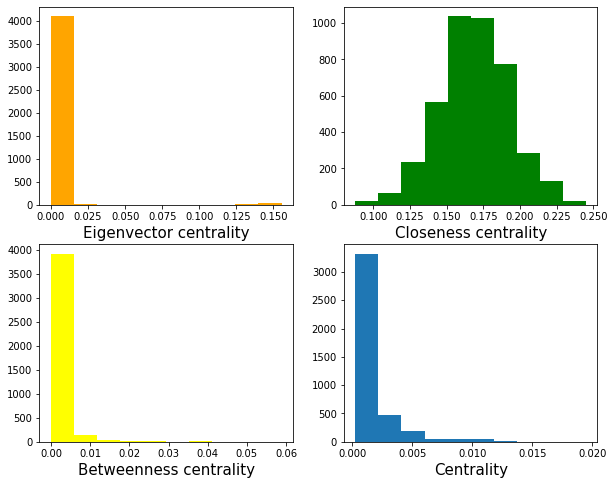

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(10, 8))
plt.subplot(221)
a=plt.hist(list(centrality.values()), color='orange')
plt.xlabel('Eigenvector centrality', fontsize=15)
plt.subplot(222)
b=plt.hist(list(close_centr.values()), color='green')
plt.xlabel('Closeness centrality', fontsize=15)
plt.subplot(223)
c=plt.hist(list(betweenc.values()), color='yellow')
plt.xlabel('Betweenness centrality', fontsize=15)
plt.subplot(224)
d=plt.hist(list(centr.values()))
plt.xlabel('Centrality', fontsize=15)


Перейдем к кластеризации. Поделим отрезок на 2 части

In [ ]:
k=2 
l=[]
for v in spread: 
    t=k*(v-df['spreading ability'].min())//(df['spreading ability'].max()-df['spreading ability'].min())
    if (t==k):
        t=k-1
    l.append(t)
Y=np.array(l)
print(Y)
print(np.bincount(l)) #тут получили, что классы примерно равны

[1. 1. 1. ... 1. 0. 1.]
[1734 2424]


Возьмем k-core из дз1

In [ ]:
def core(g):
    l_core = g.number_of_nodes()
    k = 1
    ratio = []
    while l_core:
        l_core = len(nx.k_core(g,k=k).nodes())
        ratio.append(l_core / g.number_of_nodes())
        k += 1
    return ratio       


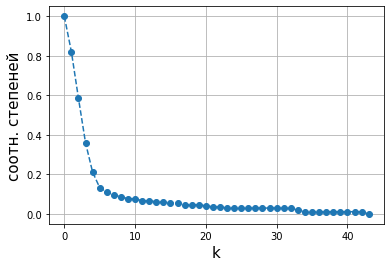

In [ ]:
P=[]
ratio = core(G)
for i in range(len(ratio)):
  P.append(i)
  i+=1
plt.plot(P, ratio, 'o--')
plt.ylabel('соотн. степеней', fontsize=15)
plt.xlabel('k', fontsize=15)
plt.grid(which='both')   

**2.Исследуйте корреляцию между признаками и целевой переменой**

Создадим датафрейм для анализа корреляции - влияния переменных друг на друга и на целевую функцию

In [ ]:
df_corr=df.copy()
df_corr['degree centrality'] = list(centr.values())
df_corr['eigenvector centrality'] = list(centrality.values())
df_corr['closeness centrality'] = list(close_centr.values())
df_corr['betweenness centrality'] = list(betweenc.values())
df_corr['target'] = list(Y)
df_corr.corr()

,node,spreading ability,degree centrality,eigenvector centrality,closeness centrality,betweenness centrality,target
node,1.000000,-0.017445,-0.016867,-0.004357,0.001905,0.002424,-0.012737
spreading ability,-0.017445,1.000000,0.008903,0.010691,-0.005100,0.023741,0.798408
degree centrality,-0.016867,0.008903,1.000000,0.600507,0.435221,0.488306,0.005637
eigenvector centrality,-0.004357,0.010691,0.600507,1.000000,0.275792,0.135088,0.014643
closeness centrality,0.001905,-0.005100,0.435221,0.275792,1.000000,0.473812,0.012798
betweenness centrality,0.002424,0.023741,0.488306,0.135088,0.473812,1.000000,0.011934
target,-0.012737,0.798408,0.005637,0.014643,0.012798,0.011934,1.000000


Рассмотрев полученные числа, видим, что нет значительной корреляции между целевой функцией target и признаками

## 2. Предсказание связей

Разбейте сеть на обучающую и тестовую выборку, тестовая выборка должна содержать как связи, которые нужно предсказать, так и отсутствующие (выберите их случайным образом, чтобы тестовая выборка была сбалансирована).

Сотрем 25% ребер

In [ ]:
G = nx.read_edgelist('email-Eu-core.txt')
edge_subset = random.sample(G.edges(), int(0.25 * G.number_of_edges()))
Gk_train = G.copy()
Gk_train.remove_edges_from(edge_subset)

Берем все связи, которые могли бы быть в графе и вычитаем уже существующие. Чтобы train и test были сбалансированы, берем рандомом


In [ ]:
train_subset = list(Gk_train.edges())
not_inc_edges = set(combinations(range(G.number_of_nodes()), 2)) -  set(map(lambda x: (int(x[0]), int(x[1])), set(G.edges()))) -  set(map(lambda x: (int(x[1]), int(x[0])), set(G.edges())))
not_inc_test = list(map(lambda x: (str(x[0]), str(x[1])), random.sample(not_inc_edges, len(edge_subset))))
not_inc_train = list(map(lambda x: (str(x[0]), str(x[1])), random.sample(not_inc_edges - set(not_inc_test), len(train_subset))))

In [ ]:
test_edges = edge_subset + not_inc_test
train_edges = train_subset + not_inc_train
y_test = [1]*len(edge_subset) + [0]*len(edge_subset)
y_train = [1]*len(train_edges) + [0]*len(train_edges)

**2. Сравните Roc-кривые для различных структурных характеристик ребер в сети. Какая лучше справляется с задачей предсказания связей по AUC ROC?**

In [ ]:
from sklearn.metrics import roc_curve, auc

In [ ]:
fpr, tpr, thresholds = roc_curve(y, scores)
roc_auc_score(y, scores)

0.9204411334872776

Text(0, 0.5, 'True Positive Rate')

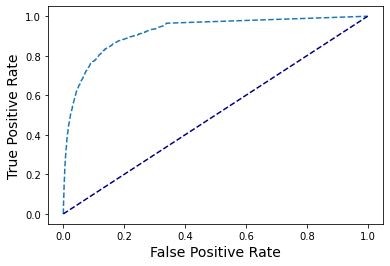

In [ ]:
plt.plot(fpr,tpr,'--')
plt.plot([0, 1], [0, 1], color="navy",  linestyle="--")
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)

In [ ]:
jaccard_test = list(nx.jaccard_coefficient(Gk_train, test_edges))
jaccard_train = list(nx.jaccard_coefficient(Gk_train, train_edges))
jaccard_test_scores = np.array(jaccard_test)[:, 2].astype(float)
fpr_jacc, tpr_jacc, thresholds = roc_curve(y_test, jaccard_test_scores)
roc_auc_score(y_test, jaccard_test_scores) #Вычислили площадь под кривой рабочих характеристик приемника (ROC AUC) по оценкам прогнозов.

0.9198996833300304

Text(0, 0.5, 'True Positive Rate')

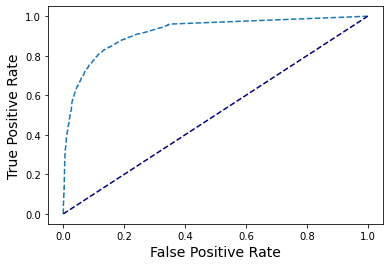

In [ ]:
plt.plot(fpr_jacc,tpr_jacc,'--')
plt.plot([0, 1], [0, 1], color="navy",  linestyle="--")
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)

In [ ]:
prediction_adamic_adar = list(nx.adamic_adar_index(Gk_train))
score_adamic, y_adamic = zip(*[(s, (u,v) in test_edges) for (u,v,s) in prediction_adamic_adar])
fpr_adamic, tpr_adamic, thresholds_ad = roc_curve(y_adamic, score_adamic)

Text(0, 0.5, 'True Positive Rate')

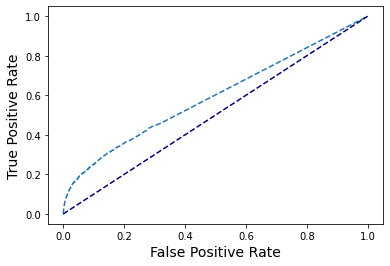

In [ ]:
plt.plot(fpr_adamic,tpr_adamic,'--')
plt.plot([0, 1], [0, 1], color="navy",  linestyle="--")
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)

In [ ]:
roc_auc_score(y_adamic, score_adamic)

0.5934116760227434

Лучше Джаккара

Постройте модель классификации, используя структурные признаки, улучшилось ли качество предсказания?

Постройте модель предскзания на основе вложения (используйте вложение сети с помощью Лапласиана или Node2vec, на выбор) Сравните качество предсказания для разных размерностей используемого пространства 𝑑 .

In [ ]:
pip install node2vec

  Created wheel for node2vec: filename=node2vec-0.4.3-py3-none-any.whl size=5978 sha256=61e11b0ffcfb172c0f9be49c89ea3299abb754c53f6233b2550bc282fee1344a
  Stored in directory: /root/.cache/pip/wheels/07/62/78/5202cb8c03cbf1593b48a8a442fca8ceec2a8c80e22318bae9
Successfully built node2vec


In [ ]:
!pip3 install nodevectors


  Created wheel for nodevectors: filename=nodevectors-0.1.23-py3-none-any.whl size=17951 sha256=5a804ef2507958872f727a2c8398ccfc7190c1887d2536fbec96d01f71ea4fa9
  Stored in directory: /root/.cache/pip/wheels/6e/6a/11/ac8620f101db6248c3cd436636eb17f6f7430cd1ac3a3068dc
  Created wheel for csrgraph: filename=csrgraph-0.1.28-py3-none-any.whl size=17632 sha256=4a356d8605c8203e9d72046aaad14eb78d403b20d6b5734a4a91e49e87d05c57
  Stored in directory: /root/.cache/pip/wheels/3d/0a/58/36a63805f1cd719cbcc5a3c4c109604985a809e7d81bac1649
Successfully built nodevectors csrgraph


In [ ]:
from node2vec import Node2Vec
from nodevectors import Node2Vec as n2

In [ ]:
class Node2Vec2(n2):
  """
  Parameters
  ----------
  p : float
      p parameter of node2vec
  q : float
      q parameter of node2vec
  d : int
      dimensionality of the embedding vectors
  """
  def __init__(self, p=1, q=1, d=32):
    super().__init__(
                     walklen=10,
                     epochs=50,
                     n_components=d,
                     return_weight=1.0/p,
                     neighbor_weight=1.0/q,
                     threads=0,
                     w2vparams={'window': 4,
                                'negative': 5, 
                                'iter': 10,
                                'ns_exponent': 0.5,
                                'batch_words': 128})

In [ ]:
# Random Walk Generation
n2v = n2(walklen=10,
                     epochs=50,
                     n_components=2,
                     return_weight=0.5,
                     neighbor_weight=2.0,
                     threads=0,
                     w2vparams={'window': 4,
                                'negative': 5, 
                                'iter': 10,
                                'ns_exponent': 0.5,
                                'batch_words': 128})
# Fittig of Skip-Gram Model
n2v.fit(Gk_train)

Making walks... 

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Done, T=24.69
Mapping Walk Names... Done, T=0.24
Training W2V... Done, T=10.75


In [ ]:
from sklearn import metrics
metrics.accuracy_score #не получилось

TypeError: ignored

## 3. Задача кластеризации (10 баллов)

1. Постройте распределение размеров сообществ в сети, какова доля вершин в наибольшем сообществе? В наименьшем?

доля вершин в самом большом сообществе: 0.10845771144278607
доля вершин в самом маленьком сообществе: 0.0009950248756218905


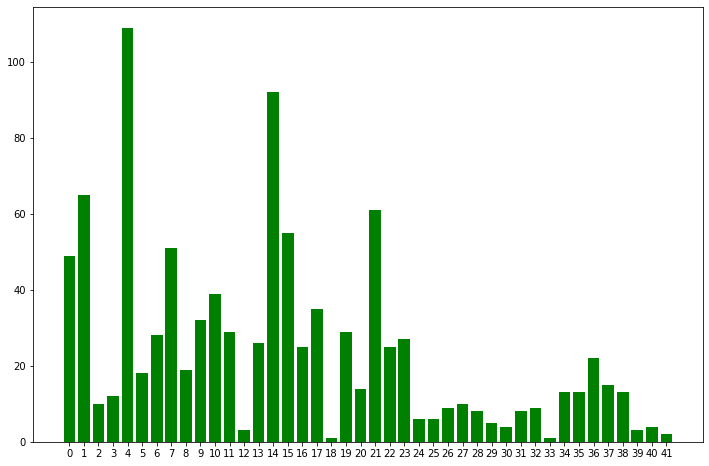

In [ ]:
email =pd.read_csv('email-Eu-core-department-labels.txt',sep=' ', names=['node', 'label'])
labels = pd.read_csv('email-Eu-core-department-labels.txt', sep=' ', names=['node', 'label'])
plt.figure(figsize=(12, 8))
plt.bar(labels['label'].value_counts().index.values, labels['label'].value_counts(), color='green')
plt.xticks(labels['label'].value_counts().index.values)
maxx=max(labels['label'].value_counts()) / len(labels)
minn=min(labels['label'].value_counts()) / len(labels)
print("доля вершин в самом большом сообществе:", maxx)
print("доля вершин в самом маленьком сообществе:", minn)

In [ ]:
email

,node,label
0,0,1
1,1,1
2,2,21
3,3,21
4,4,21
...,...,...
1000,1000,4
1001,1001,21
1002,1002,1
1003,1003,6


2. Рассмотрим задачу поиска сообществ с помощью агломеративного метода, постройте зависимость метрик качества от числа задаваемых сообществ. Какое разбиение оказывается более близким к истинному?

In [ ]:
def matrix_similarity(G, nodelist=None): 
    if (nodelist is None):
        nodelist=list(G.nodes)
    Matr=np.zeros((len(nodelist), len(nodelist)))
    for i, node1 in enumerate(nodelist):
        for j, node2 in enumerate(nodelist[i+1:], start = i+1):
            Matr[i,j]=(len(set(G[node1]) & set(G[node2])) + int(G.has_edge(node1,node2)))/(np.min([len(G[node1]),len(G[node2])])+1-int(G.has_edge(node1,node2)))
            Matr[j,i]=Matr[i,j]
    return Matr

In [ ]:
def score_agglomerative(clusters):
    result = []
    for n_clusters in clusters:
        communities = AgglomerativeClustering(linkage='average', n_clusters = n_clusters)
        X=matrix_similarity(G,nodelist=None)
        communities.fit(X)
        result.append(normalized_mutual_info_score(labels['label'].values.astype('int'), communities.labels_))
    return result
 

In [ ]:
clust = list(range(5, 50, 5))
result = score_agglomerative(clust)

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_agglomerative.py:542: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_agglomerative.py:542: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_agglomerative.py:542: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_agglomerative.py:542: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix l

In [ ]:
result

[0.04094213210015171,
 0.17021925143717995,
 0.23812812709836623,
 0.3044500646425444,
 0.3851594459991162,
 0.4245369170085096,
 0.44054513310018206,
 0.5022331977154255,
 0.5063395400328196]

Text(0, 0.5, 'Information')

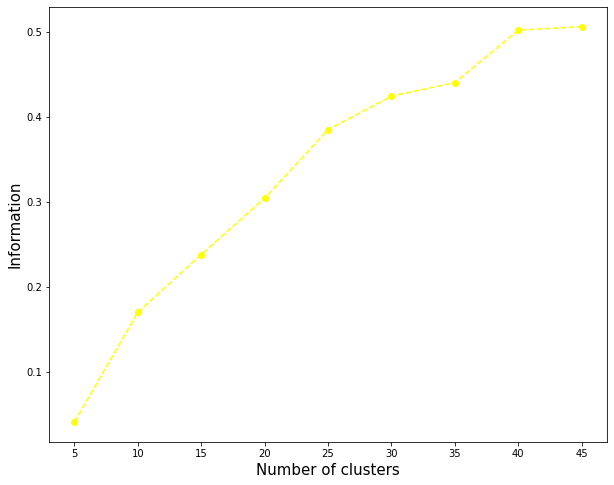

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(clust, result, 'o--', color='yellow')
plt.xticks(clust)
plt.xlabel('Number of clusters', fontsize=15)
plt.ylabel('Information', fontsize=15)

3. Выполните пункт 2) для алгоритма Гирвана-Ньюмана. Сравните качество агломеративного метода и Гирвана-Ньюмана.

In [ ]:
girvan=com.girvan_newman(G)

scores = []
num_clust = []
for j in itertools.islice(girvan, 0, 30, 2):  #Создаёт итератор по ограниченному подмножеству элементов переданного объекта.
    l=list(sorted(c) for c in j)
    num_clust.append(len(l))
    preds =  np.zeros(len(labels))
    for i, j in enumerate(l):
        for node in j:
            preds[int(node)] = i
    scores.append(normalized_mutual_info_score(labels['label'].values.astype('int'), preds))

Text(0, 0.5, 'Information')

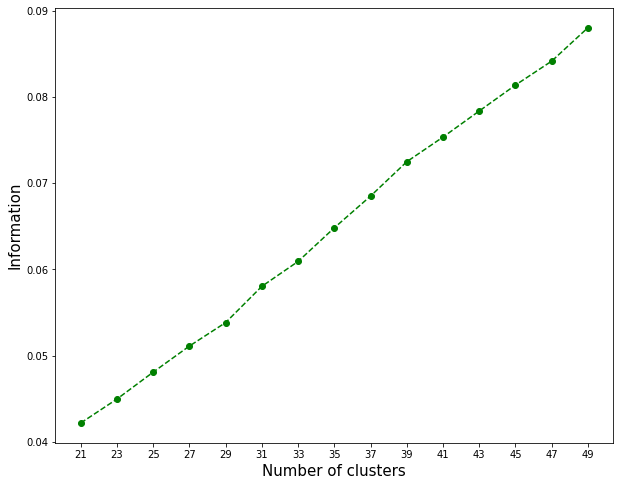

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(num_clust, scores, 'o--', color='green')
plt.xticks(num_clust)
plt.xlabel('Number of clusters', fontsize=15)
plt.ylabel('Information', fontsize=15)